## EXPLORING RESTAURANTS IN THE NEIGHBORHOODS OF HYDERABAD, INDIA


### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import csv

### Web scraping the source page using BeautifulSoup

In [2]:
page = requests.get('https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Hyderabad,_India').text
soup = BeautifulSoup(page, 'lxml')

In [3]:
csv_file = open('hyd.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

15

In [4]:
mwcg = soup.find_all(class_ = "mw-category-group")

length = len(mwcg) # Gets the length of number of `mw-category-groups` present

for i in range(0, length):  # Gets all the neighbourhoods
    lists = mwcg[i].find_all('a')
    for list in lists:
        nbd = list.get('title') # Gets the title of the neighbourhood
        csv_writer.writerow([nbd])

In [5]:
csv_file.close()

In [6]:
df = pd.read_csv("C:\\Users\\dell1\\Downloads\\Project\\hyd.csv", encoding='latin1')
df.head()

,Neighbourhood
0,A. S. Rao Nagar
1,A.C. Guards
2,Abhyudaya Nagar
3,Abids
4,Adikmet


 The data required is in two pages. Hence same procedure as above is repeated for the second page

In [7]:
page = requests.get('https://en.wikipedia.org/w/index.php?title=Category:Neighbourhoods_in_Hyderabad,_India&pagefrom=Somajiguda#mw-pages').text
soup = BeautifulSoup(page, 'lxml')

In [8]:
csv_file = open('hyd1.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighborhood'])

14

In [9]:
mwcg = soup.find_all(class_ = "mw-category-group")

length = len(mwcg) # Gets the length of number of `mw-category-groups` present

for i in range(0, length):  # Gets all the neighbourhoods
    lists = mwcg[i].find_all('a')
    for list in lists:
        nbd = list.get('title') # Gets the title of the neighbourhood
        csv_writer.writerow([nbd])

In [10]:
csv_file.close()

In [11]:
df1 = pd.read_csv("hyd1.csv")
df1.head()

,Neighborhood
0,Somajiguda
1,Srinagar colony
2,Suchitra Center
3,Sultan Bazar
4,Tarnaka


 Both the tables are joined together

In [16]:
Hyd =  pd.concat([df,df1], ignore_index=True)
Hyd

,Neighborhood
0,A. S. Rao Nagar
1,A.C. Guards
2,Abhyudaya Nagar
3,Abids
4,Adikmet


### Getting locations for the neighborhoods

In [20]:
from geopy.geocoders import Nominatim

In [ ]:
data =[]
for i in Hyd['Neighborhood']:
    try:
        print('data appended for {}'.format(i))
        geolocator = Nominatim(user_agent='foursquare_agent')
        location = geolocator.geocode(i)
        latitude = location.latitude
        longitude = location.longitude
        data.append([i,latitude, longitude])
    except:
        pass

In [ ]:
Hyderabad = pd.DataFrame(data = data, columns=['Neighborhood', 'Latitude', 'Longitude'])

In [21]:
Hyderabad.head()

,Neighborhood,Latitude,Longitude
0,A. S. Rao Nagar,17.479950,78.556834
1,A.C. Guards,17.402804,78.459487
2,Abhyudaya Nagar,17.345700,78.382700
3,Abids,17.389478,78.477182
4,Adikmet,17.409550,78.513094


### Plot of Neighborhoods on the map

In [22]:
import folium

In [23]:
# Hyderabad Location
latitude = 17.3887
longitude = 78.4610

hyd_map = folium. Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, neighbourhood in zip(Hyderabad['Latitude'], Hyderabad['Longitude'], Hyderabad['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label= folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=4,
                        popup=label,color='green',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=True).add_to(hyd_map)
hyd_map.save("Hyd_nbd.html")
hyd_map

## Data Collection from API's and Data Cleaning

### FourSquare API Credentials
It is used for obtaining the venues in a particular neighborhood

In [24]:
CLIENT_ID = '<Your CLIENT_ID>'
CLIENT_SECRET = '<Your CLIENT_SECRET>'
RADIUS = 1000 # 1 Kilometer
LIMIT = 2000
VERSION = '20200522'

### Defining Function for obtaining venues in the neighborhoods of hyderabad

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( 
            name,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Neighborhood',
                  'Venue', 
                  'Latitude', 
                  'Longitude', 
                  'Category']
    
    return(nearby_venues)

In [ ]:
fs_venues = getNearbyVenues(names=Hyderabad['Neighborhood'],
                latitudes=Hyderabad['Latitude'],
                longitudes=Hyderabad['Longitude'])

In [33]:
fs_venues.head()

,Neighborhood,Venue,Latitude,Longitude,Category
0,A. S. Rao Nagar,Cafe Coffee Day,17.481262,78.555077,Café
1,A. S. Rao Nagar,The Coffee Cup,17.483180,78.552104,Café
2,A. S. Rao Nagar,Domino's Pizza,17.475035,78.553141,Pizza Place
3,A. S. Rao Nagar,KFC,17.475040,78.553137,Fast Food Restaurant
4,A. S. Rao Nagar,Parivaar Restaurant,17.476850,78.563525,Indian Restaurant


Since we are going to explore only restaurants in this project, the venues obtained from foursquare are filtered by the category which contains only restaurants.

In [34]:
fs_venues = fs_venues[fs_venues['Category'].str.contains('Restaurant')].reset_index(drop=True)

In [35]:
fs_venues.head()

,Neighborhood,Venue,Latitude,Longitude,Category
0,A. S. Rao Nagar,KFC,17.475040,78.553137,Fast Food Restaurant
1,A. S. Rao Nagar,Parivaar Restaurant,17.476850,78.563525,Indian Restaurant
2,A. S. Rao Nagar,Swagath Grand,17.482022,78.553261,Indian Restaurant
3,A. S. Rao Nagar,McDonald's,17.476961,78.564754,Fast Food Restaurant
4,A.C. Guards,Chicha's,17.403255,78.460152,Hyderabadi Restaurant


Some of the neighborhoods are very close to each other obtaining the venues again which are in other neighborhoods. Hence these venues are considered as duplicates and are dropped.

In [36]:
fs_venues = fs_venues.drop_duplicates(subset=['Venue', 'Latitude', 'Longitude'], keep='first').reset_index()

In [38]:
fs_venues.head()

,Neighborhood,Venue,Latitude,Longitude,Category
0,A. S. Rao Nagar,KFC,17.475040,78.553137,Fast Food Restaurant
1,A. S. Rao Nagar,Parivaar Restaurant,17.476850,78.563525,Indian Restaurant
2,A. S. Rao Nagar,Swagath Grand,17.482022,78.553261,Indian Restaurant
3,A. S. Rao Nagar,McDonald's,17.476961,78.564754,Fast Food Restaurant
4,A.C. Guards,Chicha's,17.403255,78.460152,Hyderabadi Restaurant


In [39]:
fs_venues.shape

(468, 5)

Plot of Restaurants on map obtained from Foursquare 

In [40]:
hyd_map = folium.Map(location = [17.3887, 78.4610], zoom_start = 11)

for name, latitude, longitude in zip(fs_venues['Venue'], fs_venues['Latitude'], fs_venues['Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'darkblue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.5,
        parse_html = False).add_to(hyd_map)  

hyd_map.save("Foursquare.html")
hyd_map

### Zomato API

After obtaining the desired output of the foursquare venues, the venues and their locations are passed to obtain the zomato venues.

In [ ]:
headers = {'user-key': '<Your user-key>'}
venues_information = []

for index, row in fs_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['Venue'], row['Latitude'], row['Longitude'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

In [41]:
zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,KFC,17.481579,78.555268,450.0,1.0,4.1,"A 13, G1, PNR SSV Complex, Kapra Muncipality, ..."
1,Parivaar,17.477038,78.563681,1000.0,3.0,4.0,"Plot 239, ECIL, Secunderabad"
2,Kinara Grand,17.482196,78.553377,700.0,2.0,3.6,"Opposite ICICI Bank, A S Rao Nagar, Secunderabad"
3,McDonald's,17.476993,78.564792,500.0,2.0,4.0,"456/1p, HPCL Outlet, A S Rao Nagar, Secunderabad"
4,Lassi Shop,17.409005,78.460520,200.0,1.0,3.5,"6S 2S, 146/A/4, Opposite Shadan College, Chint..."


The latitudes and longitudes obtained from zomato API are strings. Hence it is converted to float

In [42]:
fs_venues['Latitude'] = fs_venues['Latitude'].apply(lambda lat: round(float(lat), 6))
fs_venues['Longitude'] = fs_venues['Longitude'].apply(lambda lat: round(float(lat), 6))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 6))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 6))

Plot of Zomato venues on map

In [43]:
hyd_map = folium.Map(location = [17.3887, 78.4610], zoom_start = 11)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(venue, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'darkred',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.5,
        parse_html = False).add_to(hyd_map)  

hyd_map.save("Zomato.html")
hyd_map

### Finally combining the two tables for obtaining final dataset

In [86]:
dataset = pd.concat([fs_venues, zomato_venues], axis = 1)

In [87]:
dataset.head()

,Neighborhood,Venue,Latitude,Longitude,Category,venue,latitude,longitude,price_for_two,price_range,rating,address
0,A. S. Rao Nagar,KFC,17.475040,78.553137,Fast Food Restaurant,KFC,17.481579,78.555268,450.0,1.0,4.1,"A 13, G1, PNR SSV Complex, Kapra Muncipality, ..."
1,A. S. Rao Nagar,Parivaar Restaurant,17.476850,78.563525,Indian Restaurant,Parivaar,17.477038,78.563681,1000.0,3.0,4.0,"Plot 239, ECIL, Secunderabad"
2,A. S. Rao Nagar,Swagath Grand,17.482022,78.553261,Indian Restaurant,Kinara Grand,17.482196,78.553377,700.0,2.0,3.6,"Opposite ICICI Bank, A S Rao Nagar, Secunderabad"
3,A. S. Rao Nagar,McDonald's,17.476961,78.564754,Fast Food Restaurant,McDonald's,17.476993,78.564792,500.0,2.0,4.0,"456/1p, HPCL Outlet, A S Rao Nagar, Secunderabad"
4,A.C. Guards,Chicha's,17.403255,78.460152,Hyderabadi Restaurant,Lassi Shop,17.409005,78.460520,200.0,1.0,3.5,"6S 2S, 146/A/4, Opposite Shadan College, Chint..."


From the above dataset, comparing the venues of foursquare and zomato there are some venues which doesn't match with their names despite being in the same location. This may be occurred due to change in restaurants name or two of them are very close to each other. Hence these venues are dropped.

In [88]:
venues = dataset.drop([2,4,6,12,16,17,18,19,22,25,26,29,30,43,45,46,49,50,51,52,53,55,56,57,58,61,64,65,67,68,69,71,72,74,76,77,86,87,90,91,
                      104,109,113,120,122,123,125,129,132,139,145,155,163,170,174,175,176,180,181,183,188,190,191,193,196,197,199,
                      203,206,207,209,210,213,220,223,224,229,230,231,232,236,239,240,241,242,244,248,249,250,253,257,258,261,265,267,269,274,276,278,289,295,298,300,
                      301,302,303,310,311,313,314,318,333,335,345,346,350,353,354,361,364,372,374,375,383,388,394,396,397,398,400,
                      401,407,408,409,410,413,414,420,430,432,443,444,446,449,450,451,452,455,458,460,467]).reset_index(drop = True)

In [89]:
venues['average_price'] = venues['price_for_two']/2
venues = venues.drop(columns = ['Venue', 'Latitude', 'Longitude', 'price_for_two'])

Finally dropping the restaurants having zero ratings

In [90]:
venues = venues[venues['rating'] != 0.0]
print("Total Restaurants available are",venues.shape[0])

Total Restaurants available are 310


In [91]:
venues.head()

,Neighborhood,Category,venue,latitude,longitude,price_range,rating,address,average_price
0,A. S. Rao Nagar,Fast Food Restaurant,KFC,17.481579,78.555268,1.0,4.1,"A 13, G1, PNR SSV Complex, Kapra Muncipality, ...",225.0
1,A. S. Rao Nagar,Indian Restaurant,Parivaar,17.477038,78.563681,3.0,4.0,"Plot 239, ECIL, Secunderabad",500.0
2,A. S. Rao Nagar,Fast Food Restaurant,McDonald's,17.476993,78.564792,2.0,4.0,"456/1p, HPCL Outlet, A S Rao Nagar, Secunderabad",250.0
3,A.C. Guards,Middle Eastern Restaurant,Jewel of Nizam - The Golkonda Hotel,17.404361,78.454107,4.0,4.3,"The Golkonda Hotel, 10-1-124, Banjara Hills, M...",1100.0
4,A.C. Guards,Hyderabadi Restaurant,Shahi Dastarkhwan,17.402515,78.461426,2.0,4.2,"Mustafa Apartment, Opposite Jamuna Ganga Hotel...",400.0


## Data Visualization

Importing required libraries

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

### Restaurant Category
Firstly we will take a look at different restaurants and their count in the neighborhoods of hyderabad.

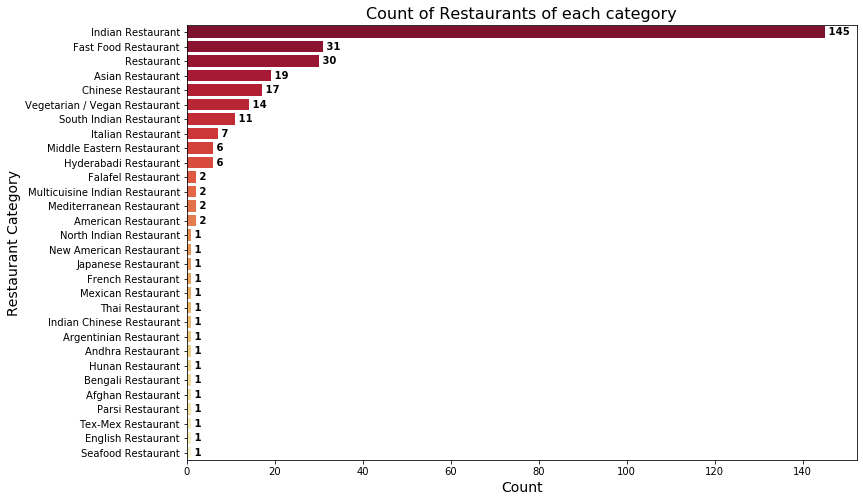

In [92]:
cat_count = venues['Category'].value_counts()
plt.figure(figsize=(12,8))
x = cat_count.values
g = sns.barplot(y = cat_count.index, x = cat_count.values, palette='YlOrRd_r')
g.set_xlabel('Count', fontsize=14)
g.set_ylabel('Restaurant Category', fontsize=14)
plt.title('Count of Restaurants of each category', fontsize=16)
for i, v in enumerate(x):
    plt.text(v, i, " "+str(v), color='black', va= 'center', fontweight= 'bold')

We can see that majority of the restaurants in Hyderabad are 'Indian Restaurants'. If some person is looking for a Indian restaurant then the person has ample of choices.

### Rating
Rating is an important factor for considering a restaurant. Hence we will see the average rating and count of ratings

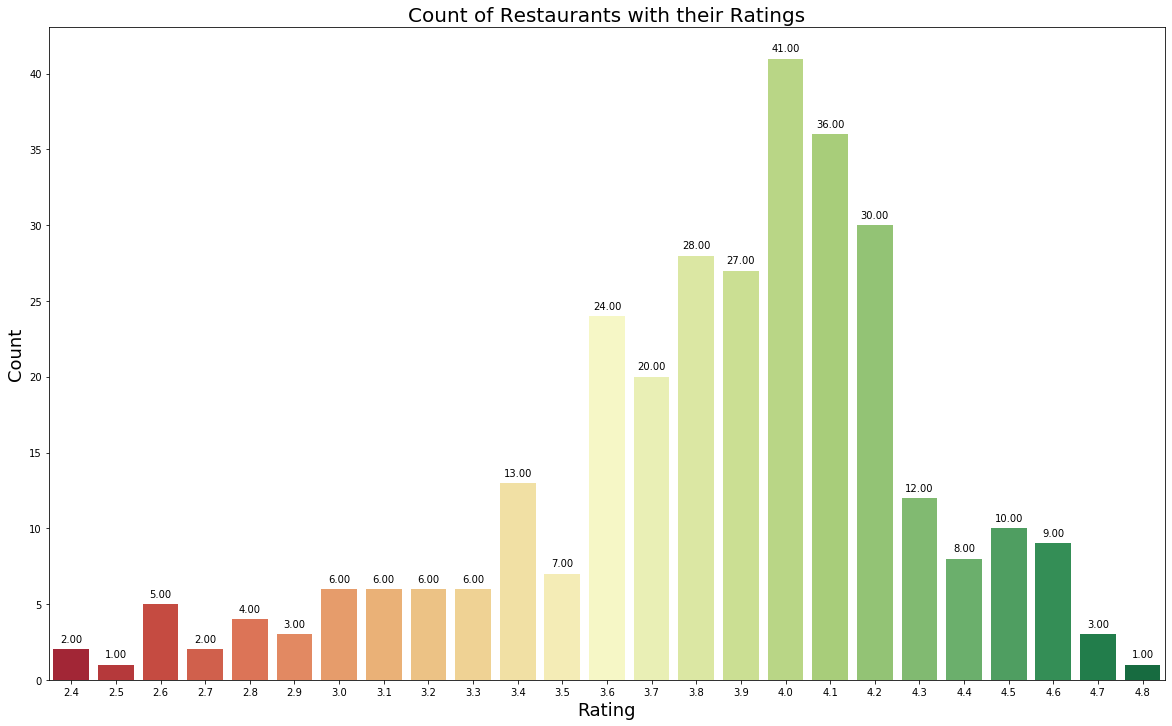

In [93]:
rating = venues['rating'].value_counts()
plt.figure(figsize = (20, 12))
g = sns.barplot(rating.index, rating.values, palette='RdYlGn')
g.set_xlabel('Rating', fontsize=18)
g.set_ylabel('Count', fontsize=18)
plt.title('Count of Restaurants with their Ratings', fontsize=20)
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width()/2,p.get_height()), ha='center', va='center', xytext=(0,10), textcoords='offset points')

We can see that the most of the restaurant having rating 4.0 with count of 41 and also the average rating close to 4.0

Creating bins for the ratings

In [110]:
bins = [1.0, 1.9, 2.9, 3.9, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
venues['rating_bin'] = pd.cut(venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Plot of restaurants according to their ratings  

In [111]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

hyd_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

for name, address, latitude, longitude, rating_bin in zip(venues['venue'], 
                                                          venues['address'], 
                                                          venues['latitude'], 
                                                          venues['longitude'], 
                                                          venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(hyd_map)  

hyd_map.save("Ratings.html")
hyd_map

### Price
Price is the main important factor for selecting a restaurant. In this project average_price and price range are taken from zomato API

First we will explore the average_price using a scatter plot.

Text(0.5, 1.0, 'Count of restaurants with their average price')

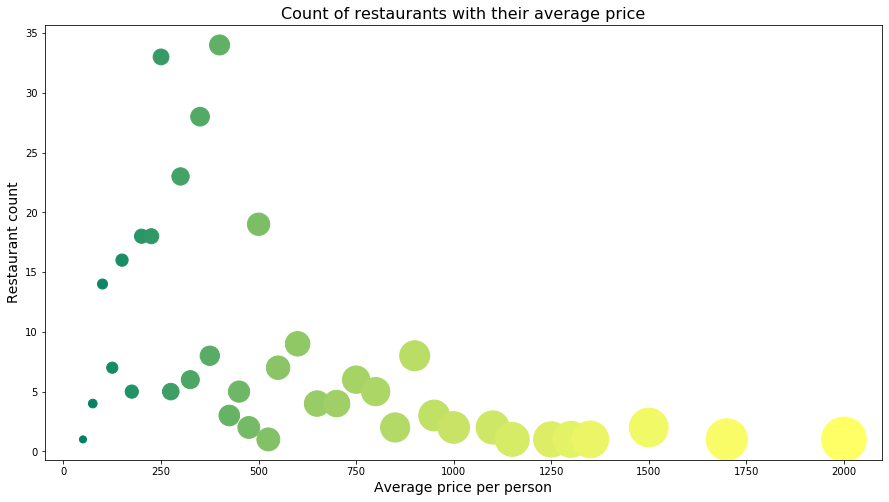

In [112]:
avg_prices = venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (15, 8))
plt.scatter(avg_prices.index, 
            avg_prices.values, 
            s = avg_prices.index, 
            c = cm.summer(np.linspace(0, 1, len(avg_prices.index))))
plt.xlabel("Average price per person", fontsize = 14)
plt.ylabel("Restaurant count", fontsize = 14)
plt.title("Count of restaurants with their average price", fontsize = 16)

From the above scatter plot we can see that most of the restaurants have an average price in between 200 and 500. 

### Plot of restaurants according to their price_range

In [97]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

hyd_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

for name, address, latitude, longitude, price_range in zip(venues['venue'], 
                                                           venues['address'], 
                                                           venues['latitude'], 
                                                           venues['longitude'], 
                                                           venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(hyd_map)  

hyd_map.save("Prices.html")
hyd_map

From the above plot we can say that the most of the restaurants in th neighborhoods of 'Jubilee Hills', 'Banjara hills' and 'Hitec City' have higher price range while compared to other neighorhoods which have mixed price range.

## Cluster Analysis

Cluster analysis helps in identifying similar groups which makes better understanding of the data. We will now cluster all the restaurants based on the price range, average price and more using K-Means Clustering. 

Clustering and adding cluster_labels

In [99]:
from sklearn.cluster import KMeans
clustering = venues.drop(['Neighborhood', 'Category', 'venue', 'address', 'rating_bin'], 1)
kMeans = KMeans(n_clusters = 2, random_state = 0).fit(clustering)
venues.insert(0, 'cluster_labels', kMeans.labels_)

In [100]:
venues.head()

,cluster_labels,Neighborhood,Category,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,A. S. Rao Nagar,Fast Food Restaurant,KFC,17.481579,78.555268,1.0,4.1,"A 13, G1, PNR SSV Complex, Kapra Muncipality, ...",225.0,Very good
1,0,A. S. Rao Nagar,Indian Restaurant,Parivaar,17.477038,78.563681,3.0,4.0,"Plot 239, ECIL, Secunderabad",500.0,Good
2,0,A. S. Rao Nagar,Fast Food Restaurant,McDonald's,17.476993,78.564792,2.0,4.0,"456/1p, HPCL Outlet, A S Rao Nagar, Secunderabad",250.0,Good
3,1,A.C. Guards,Middle Eastern Restaurant,Jewel of Nizam - The Golkonda Hotel,17.404361,78.454107,4.0,4.3,"The Golkonda Hotel, 10-1-124, Banjara Hills, M...",1100.0,Very good
4,0,A.C. Guards,Hyderabadi Restaurant,Shahi Dastarkhwan,17.402515,78.461426,2.0,4.2,"Mustafa Apartment, Opposite Jamuna Ganga Hotel...",400.0,Very good


### Plot of cluster labels

In [101]:
hyd_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
color_map = { 0: 'darkgreen', 1: 'darkred'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(venues['venue'], 
                                                        venues['address'], 
                                                        venues['cluster_labels'], 
                                                        venues['latitude'], 
                                                        venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(hyd_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(hyd_map)

hyd_map.save("Clusters.html")
hyd_map

From the above plot we can observe that cluster-0 has majority restaurants and are spread across whole city, while cluster-1 has few restaurants and are sparsely spread.

We will now explore the restaurants in both the clusters and check their average price range and rating.

### For Cluster-0

In [106]:
result = venues[venues['cluster_labels'] == 0]
print("Cluster 0")
result.reset_index(drop = True).head()

Cluster 0


,cluster_labels,Neighborhood,Category,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,A. S. Rao Nagar,Fast Food Restaurant,KFC,17.481579,78.555268,1.0,4.1,"A 13, G1, PNR SSV Complex, Kapra Muncipality, ...",225.0,Very good
1,0,A. S. Rao Nagar,Indian Restaurant,Parivaar,17.477038,78.563681,3.0,4.0,"Plot 239, ECIL, Secunderabad",500.0,Good
2,0,A. S. Rao Nagar,Fast Food Restaurant,McDonald's,17.476993,78.564792,2.0,4.0,"456/1p, HPCL Outlet, A S Rao Nagar, Secunderabad",250.0,Good
3,0,A.C. Guards,Hyderabadi Restaurant,Shahi Dastarkhwan,17.402515,78.461426,2.0,4.2,"Mustafa Apartment, Opposite Jamuna Ganga Hotel...",400.0,Very good
4,0,A.C. Guards,Vegetarian / Vegan Restaurant,Dwaraka Tiffins,17.405375,78.463669,1.0,3.4,"Hotel Rukmini Riviera, Opposite Gobal Hospital...",150.0,Good


In [107]:
print("The restaurants for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

The restaurants for cluster 0 have mean price range of 1.82 and rating spread around 3.78


From the analysis of the cluster-0, all the restaurants are clustered according to their price range(1.0, 2.0, 3.0) whose average price ranges from 50 to 600 in their partcular neighborhoods.

### For Cluster-1

In [108]:
result = venues[venues['cluster_labels'] == 1]
print("Cluster 1")
result.reset_index(drop = True).head()

Cluster 1


,cluster_labels,Neighborhood,Category,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,A.C. Guards,Middle Eastern Restaurant,Jewel of Nizam - The Golkonda Hotel,17.404361,78.454107,4.0,4.3,"The Golkonda Hotel, 10-1-124, Banjara Hills, M...",1100.0,Very good
1,1,Ameerpet,Chinese Restaurant,Mekong - Marigold Hotel,17.436455,78.454267,4.0,4.6,"Green Lands, Begumpet, Hyderabad",1500.0,Very good
2,1,Banjara Hills,Indian Restaurant,Exotica,17.410308,78.437204,3.0,4.6,"5th Floor, 12th Square Building, Road 12, Oppo...",900.0,Very good
3,1,Basheerbagh,Chinese Restaurant,Ohri's Ming's Court,17.404854,78.476556,3.0,4.7,"5-9-30/16-20, Ohri's Cuisine Court, Opposite O...",700.0,Very good
4,1,Begumpet,Thai Restaurant,Thai Pavilion - Vivanta By Taj,17.443723,78.460864,4.0,4.3,"Vivanta By Taj, 1-10-147 & 148, Mayuri Marg, B...",2000.0,Very good


In [109]:
print("The restaurants for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

The restaurants for cluster 0 have mean price range of 3.27 and rating spread around 4.24


From the analysis of the cluster-1, all the restaurants are clustered according to their price range(3.0, 4.0) whose average price ranges from 650 to 2000 in their partcular neighborhoods.